In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform, multivariate_normal

<h1 align="center"><b><u>Lecture 12 - Langevin MCMC</u></b></h1>

<h2>ULA: Unadjusted Langevin Algorithm</h2>

This notebook demonstrates the Langevin sampling algorithms. The example from the lecture slides is used, where a multivariate Gaussian is used as the target distribution. The Langevin SDE is presented below:

$$
d\mathbf{X}_t = -\nabla U(\mathbf{X}_t)dt + \sqrt{2}d\mathbf{B}_t
$$

which has stationary measure $$ \pi \propto \exp\left(-U(\mathbf{x})\right)$$

And so for a 2D Gaussian target $\pi(\mathbf{x}) = \mathcal{N}(\mathbf{x} ; \boldsymbol{\mu}, \Sigma)$, we can derive the required gradient $\nabla U(\mathbf{x}) = -\nabla \log \pi (\mathbf{x})$ as follows:

$$
\pi (\mathbf{x}) = \frac{1}{Z}\exp \left( -\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^T\Sigma^{-1}(\mathbf{x}-\boldsymbol{\mu}) \right)
$$

$$
\log \pi (\mathbf{x}) = -\log(Z) -\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^T\Sigma^{-1}(\mathbf{x}-\boldsymbol{\mu})
$$

$$
\nabla \log \pi (\mathbf{x}) = - \Sigma^{-1}(\mathbf{x}-\boldsymbol{\mu})
$$

To give the Langevin SDE for this stationary measure as seen in lectures:

$$
d\mathbf{X}_t = -\Sigma^{-1}(\mathbf{X}_t-\boldsymbol{\mu})dt + \sqrt{2} d\mathbf{B}_t
$$

In the code cell below we set the parameters of this target distribution.

In [2]:
rho = 0.8
mu = np.array([0.2,0.2])
Sigma = np.array([[1,rho],[rho,1]])
target = multivariate_normal(mean=mu, cov=Sigma)

The Unadjusted Langevin Algorithm (ULA), the Euler-Maruyama discretization is used to simulate from the SDE, which introduces a bias which we will observe. The general ULA sampling scheme is given below:

$$
X_{k+1} - X_k = -\gamma \nabla U (X_k) + \sqrt{2\gamma}W_{k+1}
$$
with $W_{k+1} \sim \mathcal{N}(0,I)$. This discretization makes the assumption that $\nabla U(\cdot)$ does not vary significantly between $X_k$ and $X_{k+1}$, and this is where the bias comes from. From the code below, note the evaluation of the target density is not required for sampling, and that we only need evaluate the gradient of the log target, and hence no normalisation constant required.


In [3]:
def ULA(initial, gradient, step_size, n):
    d = initial.shape[0]
    samples = np.zeros((n,d))
    
    x = initial
 
    for i in range(n):
        # ULA step
        y = x - (step_size*gradient(x)) + np.sqrt(2*step_size)*np.random.randn(d,)
        
        samples[i,:] = y
        x = y
        
    return samples

In [4]:
Sigma_inv = np.linalg.inv(Sigma)

In [5]:
# Gradient of negative log target for multivariate Gaussian - i.e. grad U(x)
def target_gaussian_gradient(x):
    global mu, Sigma_inv
    return Sigma_inv @ (x - mu)

Samples will now be generated from the target distribution using ULA, once with a small step size, and once with a large step size to visualise the bias introduced by ULA.

In [6]:
n = 2500
gamma_low = 0.05
gamma_high = 0.3
samples_good = ULA(np.array([0,0]), target_gaussian_gradient, step_size=gamma_low, n=n)
samples_bad = ULA(np.array([0,0]), target_gaussian_gradient, step_size=gamma_high, n=n)

In [7]:
## Plotting function for covariances
def draw_arrows(mu, C, ax, exact=True):
    if exact:
        color='black'
        z = 9
    else:
        color='white'
        z=10
    w, v = np.linalg.eig(C)
    v1 = w[0] * v[:, 0]
    v2 = w[1] * v[:, 1]
    ax.arrow(mu[0], mu[1], v1[0], v1[1], color=color, width=0.05, zorder=z)
    ax.arrow(mu[0], mu[1], -v1[0], -v1[1], color=color, width=0.05, zorder=z)
    ax.arrow(mu[0], mu[1], v2[0], v2[1], color=color, width=0.05, zorder=z)
    ax.arrow(mu[0], mu[1], -v2[0], -v2[1], color=color, width=0.05, zorder=z)

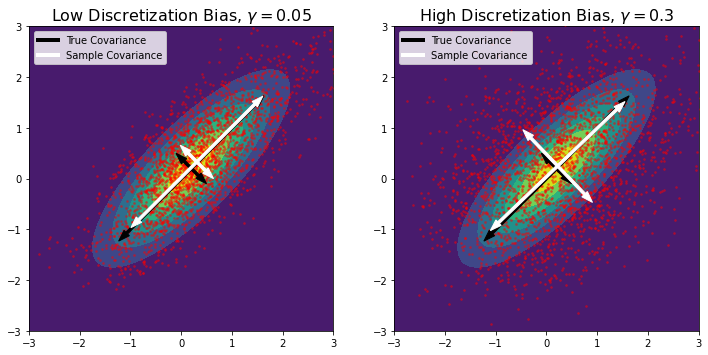

In [8]:
## Plotting
fig, ax = plt.subplots(1,2,figsize=(12,7))

ax[0].scatter(samples_good[:,0], samples_good[:,1], color='r', alpha=0.4, s=3, zorder=5)
ax[1].scatter(samples_bad[:,0], samples_bad[:,1], color='r', alpha=0.4, s=3, zorder=5)

x, y = np.mgrid[-4:4:.01, -4:4:.01]
pos = np.dstack((x, y))
ax[0].contourf(x, y, target.pdf(pos))
ax[0].set_aspect('equal')
ax[1].contourf(x, y, target.pdf(pos))
ax[1].set_aspect('equal')

C_good = np.cov(samples_good,rowvar=False)
m_good = np.mean(samples_good,axis=0)
draw_arrows(m_good, C_good, ax[0], False)
C_bad = np.cov(samples_bad,rowvar=False)
m_bad = np.mean(samples_bad,axis=0)
draw_arrows(m_bad, C_bad, ax[1], False)

draw_arrows(mu, Sigma, ax[0], True)
draw_arrows(mu, Sigma, ax[1], True)

ax[0].set_xlim((-3,3))
ax[0].set_ylim((-3,3))
ax[1].set_xlim((-3,3))
ax[1].set_ylim((-3,3))

ax[0].set_title('Low Discretization Bias, $\gamma={}$'.format(gamma_low), fontsize=16)
ax[1].set_title('High Discretization Bias, $\gamma={}$'.format(gamma_high), fontsize=16)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='black', lw=4),
                Line2D([0], [0], color='white', lw=4)]
ax[0].legend(custom_lines, ['True Covariance', 'Sample Covariance'],loc='upper left')
ax[1].legend(custom_lines, ['True Covariance', 'Sample Covariance'],loc='upper left')

plt.show()

To visualise this effect, the sample covariance is pictured alongside the true covariance of the target distribution. The lecture slides give the actual distribution being targeted when using the ULA algorithm for this case:
$$
\pi_{\gamma} = \mathcal{N}\left( \boldsymbol{\mu}, \Sigma \left( I - \frac{\gamma}{2}\Sigma^{-1} \right)^{-1} \right)
$$

In [9]:
def ULA_cov(Sigma, gamma):
    return Sigma@np.linalg.inv(np.eye(Sigma.shape[0])- (gamma/2)*np.linalg.inv(Sigma))

In [10]:
print('True Covariance')
print(Sigma)
print(r'ULA covariance, Step Size = {}'.format(gamma_low))
print(ULA_cov(Sigma, gamma_low))
print(r'ULA covariance, Step Size = {}'.format(gamma_high))
print(ULA_cov(Sigma, gamma_high))

True Covariance
[[1.  0.8]
 [0.8 1. ]]
ULA covariance, Step Size = 0.05
[[1.02696177 0.79839034]
 [0.79839034 1.02696177]]
ULA covariance, Step Size = 0.3
[[1.38181818 0.58181818]
 [0.58181818 1.38181818]]


So with a high step size, the distribution being sampled from has a less correlated structure than the true distribution, and inflated variances, which is observed in the previous figure with the sample covariance having mismatched covariance arrows in the negative sloping direction.

<h2>MALA: Metropolis Adjusted Langevin Algorithm</h2>

In order to correct for this bias, a Metropolis step can be introduced to accept or reject moves proposed by the SDE scheme.

Samples are proposed as in ULA:

$$
X_{k+1} = X_k + \gamma \nabla \log \pi(X_k) + \sqrt{2\gamma}W_{k+1}
$$

But have to introduce Metropolis step to ensure detailed balance of Markov chain and eliminate bias. We have proposed samples from the following density:

$$
X_{k+1} \sim \mathcal{N}\left( X_{k} + \gamma \nabla \log \pi(X_k), 2\gamma I \right)
$$

and so the proposal in the acceptance ratio $q(X_{k+1}|X_{k})$ is given by:

$$
q(X_{k+1}|X_{k}) = \frac{1}{\sqrt{4\pi\gamma}} \exp \left( -\frac{1}{4\gamma} \left\Vert X_{k+1} - X_{k} - \gamma \nabla \log \pi(X_k) \right\Vert^2  \right)
$$

The algorithm is exactly the same as MH, but the proposals are informed by the potential function - MALA tries to sample from areas of high density, by setting the mean of the proposal in the direction of the log-gradient. 

In [11]:
def MALA(initial, target, gradient, step_size, n):
    
    def q(x,y):
        # returns the proposal q(y|x)
        v = y - x + step_size*gradient(x)
        return np.exp(-(1/(4*step_size)) * np.square(np.linalg.norm(v)))
    
    d = initial.shape[0]
    samples = np.zeros((n,d))
    
    x = initial
    acc = 0
 
    for i in range(n):
        # Propose new sample
        y = x - (step_size*gradient(x)) + np.sqrt(2*step_size)*np.random.randn(d,)
        
        # Calculate acceptance ratio
        a = min((q(y,x) * target.pdf(y)) / (q(x,y) * target.pdf(x)), 1)
        
        # Sample from uniform on [0,1]
        u = uniform.rvs()
        
        if u <= a:
            acc += 1/n
            samples[i,:] = y
            x = y
        else:
            samples[i,:] = x

    return samples, acc

Without gradient information, we have the MH algorithm from the notebook for Lecture 5, and to demonstrate how the approaches are similar,  we use the MALA implementation to run MH. For a proposal of $X_{k+1}\sim\mathcal{N}(X_{k}, I)$, we use $\gamma=0.5$ and return zero values for the gradient, reflecting that no gradient information is used. Results are shown below, comparing acceptance rates and sample summary statistics (mean and covariance).

In [12]:
n = 10000
gamma = 0.3

samples_MALA, acc_MALA = MALA(np.array([0,0]), target, target_gaussian_gradient, step_size=gamma, n=n)
print("MALA acceptance rate: {}".format(round(acc_MALA,3)))
samples_ULA = ULA(np.array([0,0]), target_gaussian_gradient, step_size=gamma, n=n)
samples_MH, acc_MH = MALA(np.array([0,0]), target, lambda x: np.array([0,0]), 0.5, n)
print("MH acceptance rate: {}".format(round(acc_MH,3)))

MALA acceptance rate: 0.642
MH acceptance rate: 0.392


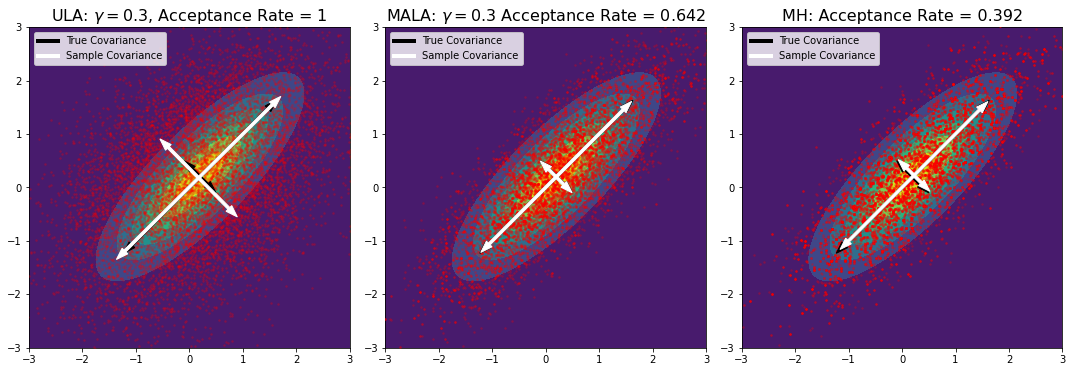

In [13]:
## Plotting
fig, ax = plt.subplots(1,3,figsize=(15,7))

ax[0].scatter(samples_ULA[:,0], samples_ULA[:,1], color='r', alpha=0.2, s=3, zorder=5)
ax[1].scatter(samples_MALA[:,0], samples_MALA[:,1], color='r', alpha=0.2, s=3, zorder=5)
ax[2].scatter(samples_MH[:,0], samples_MH[:,1], color='r', alpha=0.2, s=3, zorder=5)

x, y = np.mgrid[-4:4:.01, -4:4:.01]
pos = np.dstack((x, y))

C_ULA = np.cov(samples_ULA,rowvar=False)
m_ULA = np.mean(samples_ULA,axis=0)
draw_arrows(m_ULA, C_ULA, ax[0], False)
C_MALA = np.cov(samples_MALA,rowvar=False)
m_MALA = np.mean(samples_MALA,axis=0)
draw_arrows(m_MALA, C_MALA, ax[1], False)
C_MH = np.cov(samples_MH,rowvar=False)
m_MH = np.mean(samples_MH,axis=0)
draw_arrows(m_MH, C_MH, ax[2], False)

for axi in ax:
    draw_arrows(mu, Sigma, axi, True)
    axi.contourf(x, y, target.pdf(pos))
    axi.set_aspect('equal')
    axi.set_xlim((-3,3))
    axi.set_ylim((-3,3))

ax[0].set_title('ULA: $\gamma={}$, Acceptance Rate = {}'.format(gamma,1), fontsize=16)
ax[1].set_title('MALA: $\gamma={}$ Acceptance Rate = {}'.format(gamma,round(acc_MALA,3)), fontsize=16)
ax[2].set_title('MH: Acceptance Rate = {}'.format(round(acc_MH,3)), fontsize=16)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='black', lw=4),
                Line2D([0], [0], color='white', lw=4)]
ax[0].legend(custom_lines, ['True Covariance', 'Sample Covariance'],loc='upper left')
ax[1].legend(custom_lines, ['True Covariance', 'Sample Covariance'],loc='upper left')
ax[2].legend(custom_lines, ['True Covariance', 'Sample Covariance'],loc='upper left')
plt.tight_layout()
plt.show()

The figures above demonstrate the comparitive merits of the Langevin algorithms. ULA provides an acceptance rate of 1, which is invariant to the dimensionality of the problem and so would outperform both MALA and MH at high dimensions. However, the SDE discretization scheme in ULA introduces a significant bias at high step-size, and low step-size can provide highly correlated samples (poor mixing, try this yourself by reducing $\gamma_{\text{low}}=0.05$ to 0.001 in the first example and seeing what happens). The bias can be corrected using a Metropolis step, giving exact samples at the expense of a reduced acceptance rate that also decays with the dimension of the problem. The extra gradient information in MALA improves the acceptance rate over vanilla MH.